In [1]:
import yfinance as yf

In [2]:
sp500 = yf.Ticker("^GSPC")

In [3]:
sp500 = sp500.history(period = "max")

In [4]:
sp500 

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-06 00:00:00-05:00,4586.229980,4590.740234,4546.500000,4549.339844,4245680000,0.0,0.0
2023-12-07 00:00:00-05:00,4568.839844,4590.919922,4565.220215,4585.589844,3818880000,0.0,0.0
2023-12-08 00:00:00-05:00,4576.200195,4609.229980,4574.060059,4604.370117,3707010000,0.0,0.0


<Axes: xlabel='Date'>

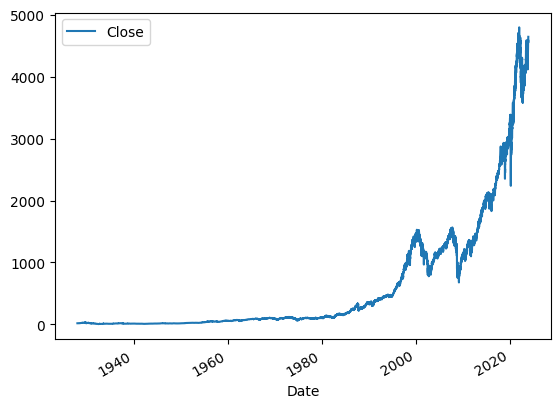

In [5]:
sp500.plot.line(y="Close",use_index=True)